In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from Extract_Observation_Tem import extract_observation_tem
from Extract_Simulated_bt import extract_simulated_bt
print(tf.__version__)

2.4.1


In [2]:
# 获取模拟亮温数据
# 模拟亮温通过Fortran和IDL程序计算得到
Years = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
         #'2007', '2008', '2009', '2010'
        ]
train_data = extract_simulated_bt(Years)
train_data.drop(['22.235', '23.035', '23.835', '26.235', '30.000'], axis=1, inplace=True)
print(f'train_data shape is {train_data.shape}')

train_data shape is (7006, 7)


In [3]:

# summer = ['05', '06', '07', '08', '09', '10']
# for i in train_data.index:
#     if i[5:7] in summer:
#         train_data.drop(i, inplace=True)
# print(f'train_data shape is {train_data.shape}')

In [4]:
# 模拟亮温数据归一化
def norm(x):
    return (x - x.describe().transpose()['mean']) / x.describe().transpose()['std']
train_data = norm(train_data)

train_data = train_data.round(3)

In [5]:
# # 模拟亮温数据拆分为data和labels
# test_data = train_data.sample(frac=0.2, random_state=1)
# train_data.drop(test_data.index, inplace=True)
# train_data = train_data.sample(frac=1)
# print(f'train_data shape is {train_data.shape}')
# print(f'test_data shape is {test_data.shape}')
#
# print(train_data.head(5))

In [6]:
# 获取观测温度数据
train_labels = extract_observation_tem(Years)
# train_labels.drop(train_labels.columns[27:], axis=1, inplace=True)
# train_labels = norm(train_labels)
train_labels = train_labels.round(3)

print(f'train_labels shape is {train_labels.shape}')

train_labels shape is (7008, 47)


In [7]:
for i in train_labels.index:
    if(train_labels.loc[i].mean())<0:
        train_labels.drop(i, inplace=True)
        train_data.drop(i, inplace=True)
train_labels.shape

(6610, 47)

In [8]:
# for i in train_labels.index:
#     if i not in train_data.index:
#         train_labels.drop(i, inplace=True)
# for i in train_data.index:
#     if i not in train_labels.index:
#         train_data.drop(i, inplace=True)

def Cross_validation(x1, x2):
    for i in x1.index:
        if i not in x2.index:
            x1.drop(i, inplace=True)
    for i in x2.index:
        if i not in x1.index:
            x2.drop(i, inplace=True)

Cross_validation(train_data, train_labels)

In [9]:
# 观测温度数据拆分为data和labels
test_labels = train_labels.sample(frac=0.2, random_state=1)
train_labels.drop(test_labels.index, inplace=True)
train_labels = train_labels.sample(frac=1)
print(f'train_labels shape is {train_labels.shape}')
print(f'test_labels shape is {test_labels.shape}')

# print(train_labels.head(5))

train_labels shape is (5286, 47)
test_labels shape is (1322, 47)


In [10]:
# 拆分模拟亮温数据
test_data = train_data.loc[test_labels.index]
train_data = train_data.loc[train_labels.index]

print(f'train_data shape is {train_data.shape}')
print(f'test_data shape is {test_data.shape}')

# print(train_data.head(5))

train_data shape is (5286, 7)
test_data shape is (1322, 7)


In [11]:
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(13, activation='relu'),
        layers.Dense(len(train_labels.keys()))
    ])

    opt = tf.keras.optimizers.RMSprop(0.001)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mse',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 13)                104       
_________________________________________________________________
dense_2 (Dense)              (None, 47)                658       
Total params: 818
Trainable params: 818
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=1500,
                    verbose=2,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1500
133/133 - 3s - loss: 56715.1562 - mae: 237.3310 - mse: 56715.1562 - val_loss: 56008.9766 - val_mae: 235.8250 - val_mse: 56008.9766
Epoch 2/1500
133/133 - 0s - loss: 55116.7852 - mae: 233.8739 - mse: 55116.7852 - val_loss: 53414.6523 - val_mae: 230.1252 - val_mse: 53414.6523
Epoch 3/1500
133/133 - 0s - loss: 51277.8047 - mae: 225.1889 - mse: 51277.8047 - val_loss: 48090.8047 - val_mae: 217.6355 - val_mse: 48090.8047
Epoch 4/1500
133/133 - 0s - loss: 44673.2031 - mae: 208.8741 - mse: 44673.2031 - val_loss: 40165.9297 - val_mae: 196.9917 - val_mse: 40165.9297
Epoch 5/1500
133/133 - 0s - loss: 36136.7969 - mae: 184.7370 - mse: 36136.7969 - val_loss: 31303.2383 - val_mae: 167.9879 - val_mse: 31303.2383
Epoch 6/1500
133/133 - 0s - loss: 28069.3516 - mae: 155.9428 - mse: 28069.3516 - val_loss: 24435.1387 - val_mae: 140.7618 - val_mse: 24435.1387
Epoch 7/1500
133/133 - 0s - loss: 22770.8750 - mae: 134.5813 - mse: 22770.8750 - val_loss: 20520.4141 - val_mae: 124.9851 - val_mse: 205

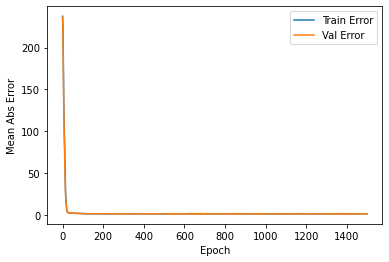

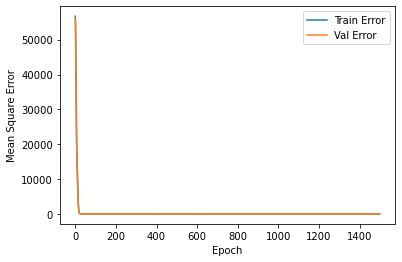

In [13]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    # plt.ylim([0, 10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    # plt.ylim([0, 70])
    plt.legend()
    plt.show()
plot_history(history)

In [14]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

42/42 [==============================] - 0s 2ms/step - loss: 5.7589 - mae: 1.7316 - mse: 5.7589
MAE:  1.73 
MSE:  5.76 
LOSS:  5.76 


In [15]:
r1 = 0
for i in range(test_data.shape[0]):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_labels[i:i + 1])
    r1 += r[0, 1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1 / test_data.shape[0]))

相关系数 0.9951


In [29]:
# for i in range(20):
flag = random.randrange(0, test_data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in test_labels.columns]
X1 = model.predict(test_data[flag:flag + 1]).T
X2 = test_labels[flag:flag + 1].T
# plt.plot(np.abs(X1 - X2), Height)
# plt.plot(X1, Height)
# plt.plot(X2, Height)
# plt.xlabel('Temperatrure K')
# plt.ylabel('Altitude km')
# plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
# plt.show()
print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
# print('平均偏差{:.4}'.format((X1-X2).mean().values))
# print(np.corcoef(X1.T,X2.T))
print(np.abs(np.mean(X1 - X2).round(4)))
print('\n')



相关系数0.9826
1998/02/23:00    0.9604
dtype: float64




<Figure size 360x720 with 0 Axes>

In [17]:
data = extract_simulated_bt('2007')
data.drop(['22.235', '23.035', '23.835', '26.235', '30.000'], axis=1, inplace=True)
data = norm(data)
labels = extract_observation_tem('2007')

In [18]:
for i in labels.index:
    if labels.loc[i].mean()<0:
        labels.drop(i, inplace=True)
        data.drop(i, inplace=True)

Cross_validation(data, labels)
print(data.shape, labels.shape)

(631, 7) (631, 47)


(1, 7)
相关系数0.994134
2007/03/10:00    4.1455
dtype: float64




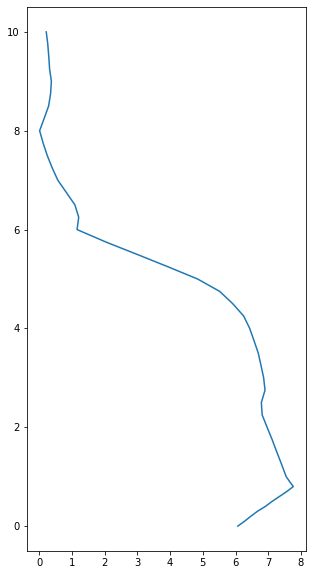

In [37]:
flag = random.randrange(0, data.shape[0])
fig = plt.figure(figsize=(5, 10))
Height = [(int(i)-1965)/1000 for i in labels.columns]
X1 = model.predict(data[flag:flag + 1]).T
X2 = labels[flag:flag + 1].T
plt.plot(np.abs(X1 - X2), Height)
# plt.plot(X1, Height)
# plt.plot(X2, Height)
# plt.xlabel('Temperatrure K')
# plt.ylabel('Altitude km')
# plt.title(test_data.index[flag])
# p = r'I:\Data\Personal_Data\graduation_project\Graduation_thesis\Atlas\Chapter6\\'
# plt.savefig(p+test_data.index[flag].replace('/', '')[:8]+'.png')
# plt.show()

print('相关系数{:.6}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
print(np.abs(np.mean(X1 - X2).round(4)))
print('\n')

In [36]:
# model.save(r'I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model0503')

INFO:tensorflow:Assets written to: I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model0503\assets
